In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

from ultralytics import utils
import torch
import torch.nn as nn 
import cv2  # For image loading
from PIL import Image
from ultralytics import Drone, FastSAM #or from your project import Drone
import numpy as np
import matplotlib.pyplot as plt
import os

Using GPU: Quadro P3200


In [41]:
#model = FastSAM("FastSAM-s.pt")
model = Drone("yolo11s-seg.pt")
model.eval()
if device == 'cuda':
    model = model.to(device)

feature_maps = {}
model.track
# Hook functions
def get_features(name):
    def hook(model, input, output):
      for item in input:
        #print("input, ", item.shape)
        #print("output", output.shape)
        feature_maps[name] = output
    return hook

model.model.model[16].register_forward_hook(get_features('sum_up'))  # this is concatenation after FPN


image_path = "test1.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

with torch.no_grad():
    results = model(image)


Call Stack:
Function: forward, File: e:\ml\ultralytics\ultralytics\nn\modules\block.py, Line: 94
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1747
Function: _wrapped_call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1736
Function: forward, File: e:\ml\ultralytics\ultralytics\nn\modules\head.py, Line: 191
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1747
Function: _wrapped_call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1736
Function: _predict_once, File: e:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 151
Function: predict, File: e:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 130
Function: forward, File: e:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 112
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\m

tensor([5.7984e+02, 6.8977e+02, 6.3706e+02, 7.5485e+02, 6.1873e-01, 2.0000e+00], device='cuda:0')
(1344, 756)


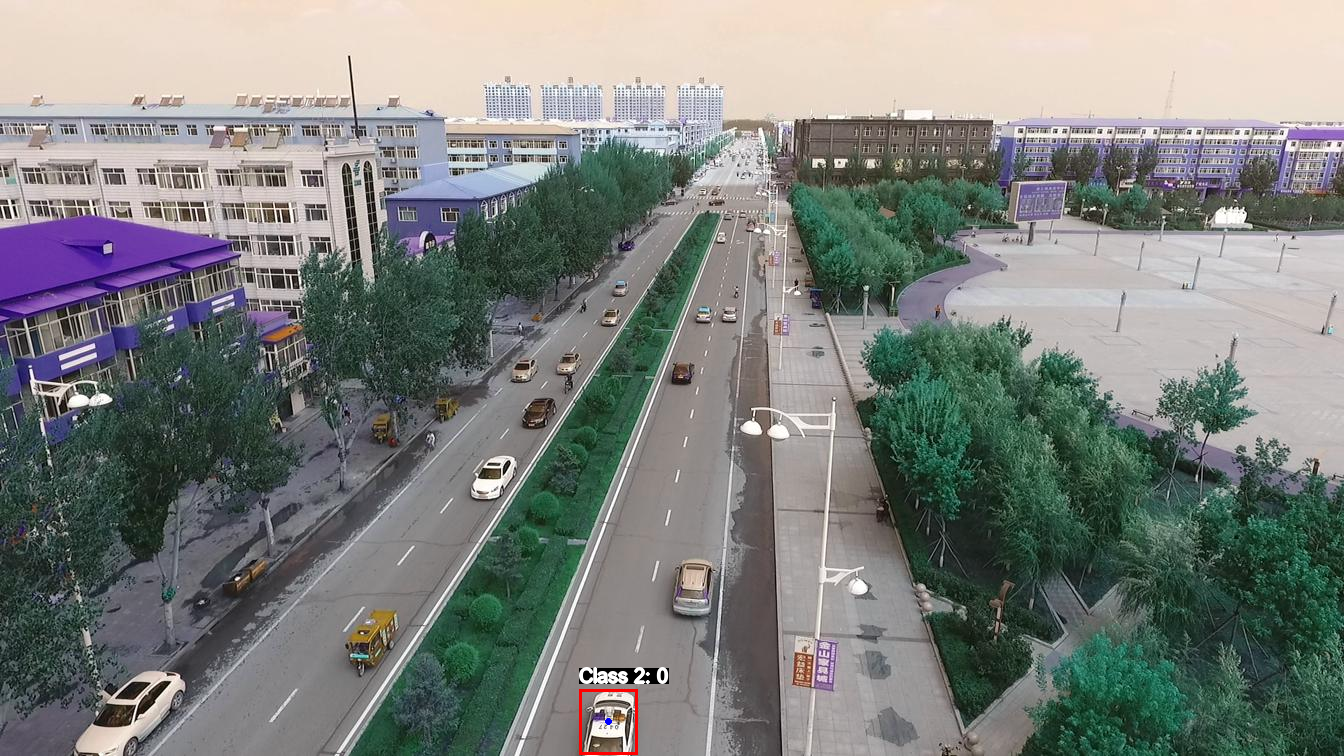

In [42]:
from PIL import Image, ImageDraw, ImageFont

def draw_bboxes(image, bboxes, font_size=20, draw_center=True):
    """
    Draw bounding boxes on an image (accepts image path, PIL Image, 
    torch.Tensor, or NumPy array).

    Args:
        image: Path to image, PIL Image, torch.Tensor (C, H, W) or (1, C, H, W), 
               or NumPy array (H, W, C) or (H,W).
        bboxes: List of bounding boxes [(x_min, y_min, x_max, y_max, conf, class_id)].
        font_size: Size of the text font.

    Returns:
        PIL Image with drawn bounding boxes.
    """

    if isinstance(image, str):  # If it's a path
        pil_image = Image.open(image).convert("RGB")  # Open and convert to RGB
        print(pil_image.size)

    elif isinstance(image, torch.Tensor):
        # Convert torch.Tensor to PIL Image
        if image.ndim == 4:  # If it has a batch dimension (1, C, H, W)
            image = image.squeeze(0)  # Remove the batch dimension

        if image.is_cuda:
            image = image.cpu()

        image = image.permute(1, 2, 0)  # Change to HWC

        if image.dtype == torch.float:
            image_numpy = image.numpy()
        elif image.dtype == torch.uint8:
            image_numpy = image.numpy() / 255.0
        else:
            raise TypeError("Tensor dtype should be either torch.float or torch.uint8")

        pil_image = Image.fromarray((image_numpy * 255).astype(np.uint8))  # Scale to 0-255 and convert to uint8
        print(pil_image.size)

    elif isinstance(image, np.ndarray):
        if image.ndim == 2:  # Grayscale image (H, W)
            pil_image = Image.fromarray(image)
            print(pil_image.size)
        elif image.ndim == 3:  # Color image (H, W, C)
            pil_image = Image.fromarray(image)
            print(pil_image.size)
        else:
            raise ValueError("Numpy array should have 2 or 3 dimensions")
    elif isinstance(image, Image.Image):  # Check if it's already a PIL Image
        pil_image = image
        print(pil_image.size)
    else:
        raise TypeError("Unsupported image type. Must be path, PIL Image, torch.Tensor, or NumPy array.")


    draw = ImageDraw.Draw(pil_image)

    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    if isinstance(bboxes, torch.Tensor):
        if bboxes.ndim == 1:  # If it's a single bounding box, wrap it in a list
            bboxes = [bboxes.tolist()]
        else:
            bboxes = bboxes.tolist()

        
    for idx, bbox in enumerate(bboxes):
        x_min, y_min, x_max, y_max, conf, class_id = map(int, bbox[:6])

        # Draw the rectangle
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

        # Format text
        text = f'Class {class_id}: {idx}'
        text_position = (x_min, max(0, y_min - font_size - 5))

        text_size = draw.textbbox(text_position, text, font=font)  # Get text size
        draw.rectangle(text_size, fill="black")  # Background rectangle

        for offset in [-1, 0, 1]:
            draw.text((text_position[0] + offset, text_position[1]), text, font=font, fill="white")
            draw.text((text_position[0], text_position[1] + offset), text, font=font, fill="white")

        if draw_center:
            center_x = (x_min + x_max) // 2
            center_y = (y_min + y_max) // 2
            draw.ellipse((center_x - 3, center_y - 3, center_x + 3, center_y + 3), fill="blue")


    return pil_image

# Example usage

image = results[0].orig_img
bboxes = results[0].pred[3, :6]
print(bboxes)
draw_bboxes(image, bboxes)

In [43]:
results[0].orig_img.shape

(756, 1344, 3)

In [44]:
import torch
import numpy as np

# Assuming results[0].boxes.data[3] is your tensor
point = results[0].boxes.data[3].clone()
if point.is_cuda:
    point = point.cpu()

# Convert to NumPy
point_np = point.numpy()

# Set NumPy print options to display full precision
np.set_printoptions(precision=10)  # Adjust precision as needed

# Print the NumPy array
print(point_np)
print(type(point_np))

#Reset print options
np.set_printoptions(precision=8)

[5.7984222e+02 6.8977155e+02 6.3705682e+02 7.5484766e+02 6.1873209e-01 2.0000000e+00]
<class 'numpy.ndarray'>


In [45]:

image_size = results[0].orig_img.shape
print(image_size)
scaled_preds = utils.ops.scale_boxes(image_size, point_np, (48, 80)) # (48, 80) is size of feature map from layer 16
print(scaled_preds)

mid_x = (scaled_preds[0] + scaled_preds[2]) / 2
mid_y = (scaled_preds[1] + scaled_preds[3]) / 2

midpoint = (mid_x, mid_y)  # Store as a tuple

print(f"Midpoint: {midpoint}")

(756, 1344, 3)
[34.148712  43.795017  37.781387  47.926834   0.6187321  2.       ]
Midpoint: (35.965049743652344, 45.860923767089844)


In [46]:
print(results[0].boxes.data[3], results[0].scaled_preds[3])


mid_x = (results[0].scaled_preds[3][0] + results[0].scaled_preds[3][2]) / 2
mid_y = (results[0].scaled_preds[3][1] + results[0].scaled_preds[3][3]) / 2

midpoint = (mid_x, mid_y)  # Store as a tuple

print(f"Midpoint: {midpoint}")

tensor([5.7984e+02, 6.8977e+02, 6.3706e+02, 7.5485e+02, 6.1873e-01, 2.0000e+00], device='cuda:0') tensor([34.5144, 42.5578, 37.9201, 46.4314], device='cuda:0')
Midpoint: (tensor(36.2172, device='cuda:0'), tensor(44.4946, device='cuda:0'))


In [5]:
feature_maps["sum_up"].shape

torch.Size([1, 128, 48, 80])

In [6]:
results[0].orig_shape

(1080, 1920)

In [7]:
sum_up = feature_maps['sum_up'][0]
sum_up.shape, sum_up.shape[1:]

(torch.Size([128, 48, 80]), torch.Size([48, 80]))

In [8]:
masks = results[0].masks.data
results[0].masks.data.shape

torch.Size([60, 384, 640])

In [9]:
img = results[0].img
#img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
img.shape

torch.Size([1, 3, 384, 640])

In [10]:
masks = results[0].masks.data
masks.shape, type(masks)

(torch.Size([60, 384, 640]), torch.Tensor)

In [11]:
results[0].masks.data.shape

torch.Size([60, 384, 640])

In [12]:
results[0].boxes.xyxy.shape

torch.Size([60, 4])

In [13]:
proto = results[0].proto
pred = results[0].pred
proto.shape, pred.shape

(torch.Size([32, 96, 160]), torch.Size([60, 38]))

In [14]:
pred[:, :6], results[0].scaled_preds

(tensor([[1.2058e+03, 7.7577e+02, 1.3456e+03, 8.7338e+02, 8.7661e-01, 2.0000e+00],
         [9.2315e+02, 9.2809e+02, 1.0680e+03, 1.0410e+03, 8.4473e-01, 2.0000e+00],
         [8.0506e+02, 8.1428e+02, 9.5958e+02, 9.2908e+02, 8.3435e-01, 2.0000e+00],
         [8.5769e+02, 8.6420e+02, 1.0190e+03, 9.8309e+02, 8.0966e-01, 2.0000e+00],
         [1.2628e+03, 8.3826e+02, 1.4053e+03, 9.5323e+02, 7.8684e-01, 2.0000e+00],
         [7.5440e+02, 5.3180e+02, 8.3260e+02, 6.1567e+02, 7.8160e-01, 2.0000e+00],
         [1.1563e+03, 7.0759e+02, 1.2913e+03, 7.9231e+02, 7.6060e-01, 2.0000e+00],
         [9.9471e+02, 1.0107e+03, 1.1357e+03, 1.0800e+03, 7.2088e-01, 2.0000e+00],
         [7.9484e+02, 4.5707e+02, 8.6914e+02, 5.2117e+02, 6.8272e-01, 2.0000e+00],
         [1.1035e+03, 6.5099e+02, 1.2328e+03, 7.3457e+02, 6.6772e-01, 2.0000e+00],
         [1.0503e+03, 5.9807e+02, 1.1809e+03, 6.7490e+02, 6.2171e-01, 2.0000e+00],
         [7.1371e+02, 6.8894e+02, 8.5858e+02, 7.8307e+02, 5.8686e-01, 2.0000e+00],
    

In [15]:
sum_up.shape[1:], img.shape[2:]

(torch.Size([48, 80]), torch.Size([384, 640]))

In [16]:
masks.shape

torch.Size([60, 384, 640])

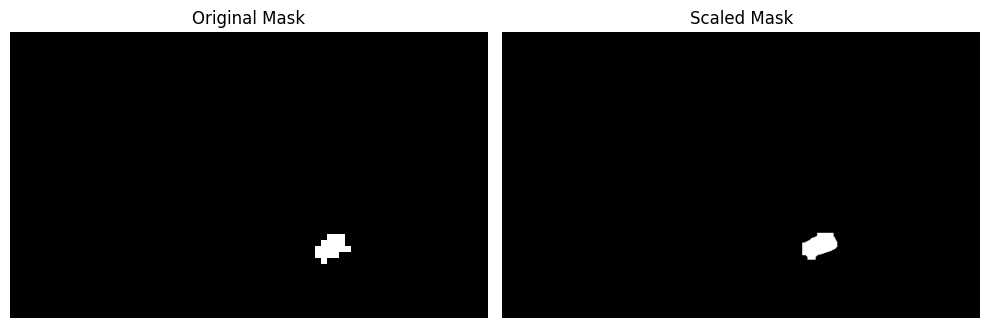

In [17]:
import torch.nn.functional as F

mask_np = masks.cpu().numpy()
mask_tensor = torch.tensor(mask_np)
short = F.interpolate(masks.unsqueeze(1), size=(48, 80), mode="nearest").squeeze(1)
short = short.cpu().numpy()


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

if short.ndim == 3:
    short = short[0]  # Remove the first dimension
if mask_np.ndim == 3:
    mask_np = mask_np[0]  # Remove the first dimension

# Plot the original and scaled masks
#fig, ax = plt.subplots(1, 2, figsize=(10, 5))
 # Original mask
ax[0].imshow(short, cmap="gray")
ax[0].set_title("Original Mask")
ax[0].axis("off")

# Scaled mask
ax[1].imshow(mask_np, cmap="gray")
ax[1].set_title("Scaled Mask")
ax[1].axis("off")

plt.tight_layout()
plt.show()

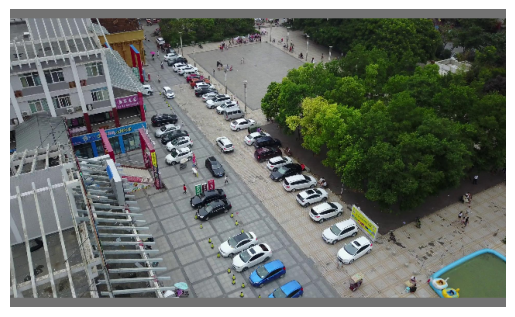

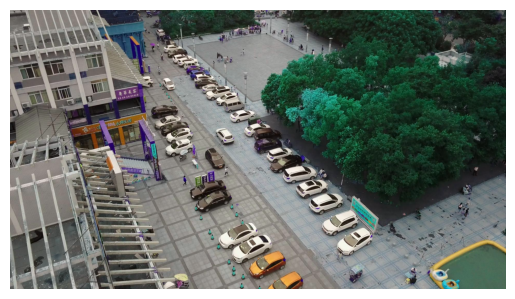

In [18]:
import torch
import torch
import matplotlib.pyplot as plt
import numpy as np

def show_image(image):
    """Displays either a PyTorch tensor or a NumPy array representing an image.

    Args:
        image: Either a PyTorch tensor (C, H, W) or (1, C, H, W) or a NumPy array (H, W, C) or (H, W). Values should be between 0 and 1 (for floats) or 0 and 255 (for uint8).
    """

    if isinstance(image, torch.Tensor):  # Check if it's a PyTorch tensor
        # 1. Check and remove batch dimension if present
        if image.ndim == 4:  # If it has a batch dimension (1, C, H, W)
            image = image.squeeze(0)  # Remove the batch dimension

        # 2. Check for CUDA tensor and move to CPU if needed
        if image.is_cuda:
            image = image.cpu()

        # 3. Permute the dimensions to (H, W, C) for Matplotlib
        image = image.permute(1, 2, 0)

        # 4. If the tensor is float, it's assumed to be in the range [0, 1].  If it's int, it's assumed to be in [0, 255]
        if image.dtype == torch.float:
            image_numpy = image.numpy()
        elif image.dtype == torch.uint8:  # Check if it is in uint8
            image_numpy = image.numpy() / 255.0  # Normalize if it is in uint8
        else:
            raise TypeError("Tensor dtype should be either torch.float or torch.uint8")


    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        if image.ndim == 2:  # Grayscale image (H, W)
          image_numpy = image
        elif image.ndim == 3:  # Color image (H, W, C)
          image_numpy = image
        else:
          raise ValueError("Numpy array should have 2 or 3 dimensions")

    else:
        raise TypeError("Input should be a PyTorch tensor or a NumPy array.")

    # 5. Display the image
    plt.imshow(image_numpy)
    plt.axis('off')  # Hide axes
    plt.show()

show_image(results[0].img)
show_image(results[0].orig_img)

In [19]:
masks = results[0].masks.data
scaled_preds = results[0].scaled_preds

scaled_preds.shape, masks.shape   # BBoxes,  MAsks


(torch.Size([60, 4]), torch.Size([60, 384, 640]))

In [20]:
def visualize_cropped_regions(features, masks, scaled_bboxes, processed_regions):
    """
    Visualize the cropped regions of masks and features.

    Args:
        features (torch.Tensor): Original feature tensor of shape [1, C, H_f, W_f].
        masks (torch.Tensor): Binary masks tensor of shape [N, H_m, W_m].
        scaled_bboxes (torch.Tensor): Bounding boxes tensor of shape [N, 4] (x_min, y_min, x_max, y_max).
        processed_regions (list): List of processed regions from `process_features_masks_bbs`.
    """
    _, C, H_f, W_f = features.shape

    for region in processed_regions:
        mask_idx, channel_idx, masked_features = region

        if channel_idx is None:
            print(f"Mask {mask_idx}: Cropped region is too small, skipping visualization.")
            continue

        # Original bounding box
        x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()

        # Visualize cropped mask
        cropped_mask = masks[mask_idx, int(y_min):int(y_max), int(x_min):int(x_max)].cpu().numpy()

        # Visualize cropped feature map (single channel)
        cropped_feature = masked_features.cpu().numpy()

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        # Cropped mask visualization
        ax[0].imshow(cropped_mask, cmap="gray")
        ax[0].set_title(f"Mask {mask_idx} - Cropped Region")
        ax[0].axis("off")

        # Cropped feature visualization (for the specified channel)
        ax[1].imshow(cropped_feature, cmap="viridis")
        ax[1].set_title(f"Channel {channel_idx} - Masked Features")
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()

In [21]:
def draw_bboxes(image, bboxes, similarity_score = None, font_size=20):
    """
    Draw bounding boxes on an image (accepts image path, PIL Image, 
    torch.Tensor, or NumPy array).

    Args:
        image: Path to image, PIL Image, torch.Tensor (C, H, W) or (1, C, H, W), 
               or NumPy array (H, W, C) or (H,W).
        bboxes: List of bounding boxes [(x_min, y_min, x_max, y_max, conf, class_id)].
        font_size: Size of the text font.

    Returns:
        PIL Image with drawn bounding boxes.
    """
    
    if isinstance(image, str):  # If it's a path
        pil_image = Image.open(image).convert("RGB")  # Open and convert to RGB
    elif isinstance(image, torch.Tensor):
        # Convert torch.Tensor to PIL Image
        if image.ndim == 4:  # If it has a batch dimension (1, C, H, W)
            image = image.squeeze(0)  # Remove the batch dimension

        if image.is_cuda:
            image = image.cpu()

        image = image.permute(1, 2, 0)  # Change to HWC

        if image.dtype == torch.float:
            image_numpy = image.numpy()
        elif image.dtype == torch.uint8:
            image_numpy = image.numpy() / 255.0
        else:
            raise TypeError("Tensor dtype should be either torch.float or torch.uint8")

        pil_image = Image.fromarray((image_numpy * 255).astype(np.uint8))  # Scale to 0-255 and convert to uint8

    elif isinstance(image, np.ndarray):
        if image.ndim == 2:  # Grayscale image (H, W)
            pil_image = Image.fromarray(image)
        elif image.ndim == 3:  # Color image (H, W, C)
            pil_image = Image.fromarray(image)
        else:
            raise ValueError("Numpy array should have 2 or 3 dimensions")
    elif isinstance(image, Image.Image):  # Check if it's already a PIL Image
        pil_image = image
    else:
        raise TypeError("Unsupported image type. Must be path, PIL Image, torch.Tensor, or NumPy array.")


    draw = ImageDraw.Draw(pil_image)

    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    if isinstance(bboxes, list):  # If it's not already a list, make it one
        bboxes = [bboxes]

    if isinstance(bboxes, torch.Tensor):
        if bboxes.ndim == 1:  # If it's a single bounding box, wrap it in a list
            bboxes = [bboxes.tolist()]
        else:
            bboxes = bboxes.tolist()
    
    for idx, bbox in enumerate(bboxes):
        x_min, y_min, x_max, y_max, conf, class_id = map(int, bbox[:6])
        
        if similarity_score is None:
            similarity_score = conf
            color = "green"
        else:
            color = "red"
        draw.rectangle([x_min, y_min, x_max, y_max], outline=color, width=3)

        # Format text
        text = f'id {idx}: {similarity_score}'
        text_position = (x_min, max(0, y_min - font_size - 5))

        text_size = draw.textbbox(text_position, text, font=font)  # Get text size
        draw.rectangle(text_size, fill="black")  # Background rectangle

        for offset in [-1, 0, 1]:
            draw.text((text_position[0] + offset, text_position[1]), text, font=font, fill="white")
            draw.text((text_position[0], text_position[1] + offset), text, font=font, fill="white")

    return pil_image

In [73]:
point = np.array([34.60334396362305, 42.15312194824219, 37.76932144165039, 46.53242492675781])
image_size = [1920, 1080]
scaled_preds = utils.ops.scale_boxes(image_size, point, (48, 80)) # (48, 80) is size of feature map from layer 16
print(scaled_preds)

mid_x = (scaled_preds[0] + scaled_preds[2]) / 2
mid_y = (scaled_preds[1] + scaled_preds[3]) / 2

midpoint = (mid_x, mid_y)  # Store as a tuple

print(f"Midpoint: {midpoint}")

[     2.5632           0      2.7977           0]
Midpoint: (2.6804690890842013, 0.0)


Original

In [41]:
import torch
import torch.nn.functional as F
import torch.nn as nn
#ORIGINAL
class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, out_channels, reference_mask=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size=1).to(device)
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.target_size = target_size
        self.out_channels = out_channels
        
    def forward(self, features, masks, scaled_bboxes, reference_mask=None):
        _, C, H_f, W_f = features.shape  # Features dimensions
        N, H_m, W_m = masks.shape       # Masks dimensions
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), device=features.device)

        if scaled_bboxes.shape[0] != N:
            raise ValueError(f"Number of bounding boxes ({scaled_bboxes.shape[0]}) does not match the number of masks ({N}).")

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  # Skip invalid bounding boxes
            
            cropped_features = features[:, :, int(y_min):int(y_max), int(x_min):int(x_max)]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[int(y_min):int(y_max), int(x_min):int(x_max)]
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat

        # Reduce channels from [N, C, 16, 16] → [N, out_channels, 16, 16]
        processed_reduced = self.reduce_channels(processed_regions)

        if reference_mask is not None:
            self.reference_mask = reference_mask
        if self.reference_mask is None:
            self.reference_mask = processed_reduced[3]

        processed_flattened = processed_reduced.view(N, -1)  # [N, out_channels*16*16]
        reference_flattened = self.reference_mask.flatten().unsqueeze(0)  # [1, out_channels*16*16]
        similarity = F.cosine_similarity(processed_flattened, reference_flattened, dim=1)
        most_similar_idx = torch.argmax(similarity).item()
        similarity_score = similarity[most_similar_idx].item()  # Get the similarity score
        
        if similarity_score >= 0.1:  # Check if similarity is at least 50%
            self.reference_mask = processed_reduced[most_similar_idx]
        
        return {"bboxes":processed_reduced[most_similar_idx], "most_similar_idx":most_similar_idx, "similarity_score":similarity_score}

    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = x.flatten(2)  # Flatten H and W dimensions to create a 1D "sequence" for each channel. Shape: [N, C, H*W]
        x = self.conv1d(x)  # Apply the 1D convolution. Shape: [N, out_channels, H*W]
        x = x.view(N, self.out_channels, H, W)  # Reshape back to [N, out_channels, H, W]
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = VideoMaskProcessor(in_channels=128, out_channels=32, device=device)

##Example Usage
#features = feature_maps["sum_up"]  # [1, 128, H_f, W_f]
#maskss = masks  # Binary masks [N, H_m, W_m]
#bboxes = scaled_preds  # [N, 4]
#reference_mask = torch.randn(32, 16, 16, device=features.device)  # Shape [128, 16, 16]
#
## Process and find the most similar mask
#most_similar_mask, most_similar_idx, similarity_score = processor(features, maskss, bboxes, reference_mask)
#
#print(f"processed_reduced : {most_similar_idx}")

Kalman Filter + cosine similarity weitage

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from filterpy.kalman import KalmanFilter
#OPENAI 1
class KalmanBoxTracker:
    def __init__(self, bbox):
        """
        Initialize a Kalman filter to track the bounding box [x_min, y_min, x_max, y_max].
        """
        self.kf = KalmanFilter(dim_x=8, dim_z=4)  # 8 states (position + velocity), 4 measurements (bbox)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],   # Transition matrix
                              [0, 1, 0, 0, 0, 1, 0, 0],   
                              [0, 0, 1, 0, 0, 0, 1, 0],   
                              [0, 0, 0, 1, 0, 0, 0, 1],   
                              [0, 0, 0, 0, 1, 0, 0, 0],   
                              [0, 0, 0, 0, 0, 1, 0, 0],   
                              [0, 0, 0, 0, 0, 0, 1, 0],   
                              [0, 0, 0, 0, 0, 0, 0, 1]])
        
        self.kf.H = np.eye(4, 8)  # Observation matrix (bbox directly observed)
        self.kf.R *= 10  # Measurement noise
        self.kf.P *= 100  # Initial uncertainty
        self.kf.Q *= 0.01  # Process noise
        
        self.kf.x[:4] = np.array(bbox).reshape(4, 1)  # Initialize state with bbox
        self.age = 0
    
    def predict(self):
        """
        Predict the next bounding box position.
        """
        self.kf.predict()
        self.age += 1
        return self.kf.x[:4].flatten()  # Return predicted bbox

    def update(self, bbox):
        """
        Update the Kalman Filter with the detected bounding box.
        """
        self.kf.update(np.array(bbox).reshape(4, 1))

class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, out_channels, reference_mask=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size=1).to(device)
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.target_size = target_size
        self.out_channels = out_channels
        self.tracker = None  # Initialize tracker later
        
    def forward(self, features, masks, scaled_bboxes, reference_mask=None):
        _, C, H_f, W_f = features.shape  
        N, H_m, W_m = masks.shape
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), device=features.device)

        if scaled_bboxes.shape[0] != N:
            raise ValueError(f"Number of bounding boxes ({scaled_bboxes.shape[0]}) does not match the number of masks ({N}).")

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  # Skip invalid bounding boxes
            
            cropped_features = features[:, :, int(y_min):int(y_max), int(x_min):int(x_max)]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[int(y_min):int(y_max), int(x_min):int(x_max)]
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat


        processed_reduced = self.reduce_channels(processed_regions)

        if reference_mask is not None:
            self.reference_mask = reference_mask
        if self.reference_mask is None:
            self.reference_mask = processed_reduced[3]  

        processed_flattened = processed_reduced.view(N, -1)  
        reference_flattened = self.reference_mask.flatten().unsqueeze(0)  

        cosine_sim = F.cosine_similarity(processed_flattened, reference_flattened, dim=1)

        # Initialize or update Kalman filter
        if self.tracker is None:
            self.tracker = KalmanBoxTracker(scaled_bboxes[3].tolist())
        predicted_bbox = torch.tensor(self.tracker.predict(), device=features.device)  # Predict next position

        # Compute distance between predicted bbox and each detected bbox
        centroids = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
        predicted_centroid = (predicted_bbox[:2] + predicted_bbox[2:]) / 2
        euclidean_dist = torch.norm(centroids - predicted_centroid, dim=1)
        normalized_dist = euclidean_dist / euclidean_dist.max()

        # Compute weighted similarity
        alpha = 0.3  #increase for similarity  
        weighted_similarity = (alpha * cosine_sim) - ((1 - alpha) * normalized_dist)

        most_similar_idx = torch.argmax(weighted_similarity).item()
        similarity_score = weighted_similarity[most_similar_idx].item()

        # Update Kalman filter with selected bbox
        self.tracker.update(scaled_bboxes[most_similar_idx].tolist())

        if similarity_score >= 0.1:
            self.reference_mask = processed_reduced[most_similar_idx]

        return processed_reduced[most_similar_idx], most_similar_idx, similarity_score

    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = x.flatten(2)
        x = self.conv1d(x)
        x = x.view(N, self.out_channels, H, W)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = VideoMaskProcessor(in_channels=128, out_channels=32, device=device)

Occlusion Recovery

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from filterpy.kalman import KalmanFilter
import torchvision.ops as ops
#OPENAI 2 good without memory
class KalmanBoxTracker:
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=8, dim_z=4)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],   
                              [0, 1, 0, 0, 0, 1, 0, 0],   
                              [0, 0, 1, 0, 0, 0, 1, 0],   
                              [0, 0, 0, 1, 0, 0, 0, 1],   
                              [0, 0, 0, 0, 1, 0, 0, 0],   
                              [0, 0, 0, 0, 0, 1, 0, 0],   
                              [0, 0, 0, 0, 0, 0, 1, 0],   
                              [0, 0, 0, 0, 0, 0, 0, 1]])
        
        self.kf.H = np.eye(4, 8)
        self.kf.R *= 10
        self.kf.P *= 100
        self.kf.Q *= 0.01
        
        self.kf.x[:4] = np.array(bbox).reshape(4, 1)
        self.age = 0
    
    def predict(self):
        self.kf.predict()
        self.age += 1
        return self.kf.x[:4].flatten()

    def update(self, bbox):
        self.kf.update(np.array(bbox).reshape(4, 1))

class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, out_channels, reference_mask=None, reference_bboxes=None, bert_projection=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.device = device
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size=1).to(device)
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.target_size = target_size
        self.out_channels = out_channels
        self.tracker = None
        self.is_occluded = False
        self.occlusion_counter = 0
        self.reference_bboxes = reference_bboxes
        self.bert_projection = bert_projection
        self.occlusion_threshold = 0.2
        self.occlusion_frames = 5
        self.reid_threshold = 0.95
        self.first_iter = True
        
    def forward(self, features, masks, scaled_bboxes, reference_mask=None, alpha = 0.6):
            
        _, C, H_f, W_f = features.shape  
        N, H_m, W_m = masks.shape
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), device=self.device)
        output = {}
        if scaled_bboxes.shape[0] != N:
            raise ValueError(f"Number of bounding boxes ({scaled_bboxes.shape[0]}) does not match the number of masks ({N}).")

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  
            
            cropped_features = features[:, :, int(y_min):int(y_max), int(x_min):int(x_max)]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[int(y_min):int(y_max), int(x_min):int(x_max)]
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat

        processed_reduced = self.reduce_channels(processed_regions)
                  
            
        if self.first_iter:    #TODO implement bert projection 
            self.reference_mask = processed_reduced[4]  #TODO Should be given
            self.first_iter = False

        # Occlusion recovery
        if self.is_occluded:            
            processed_flattened = processed_reduced.view(N, -1) 
            reference_flattened = self.reference_mask.flatten().unsqueeze(0) 
            cosine_sim = F.cosine_similarity(processed_flattened, reference_flattened, dim=1)
            cosine_sim = (cosine_sim + 1) / 2 
            max_sim, max_idx = torch.max(cosine_sim, dim=0)

            if max_sim >= self.reid_threshold:
                self.is_occluded = False
                self.occlusion_counter = 0
                self.reference_bboxes = scaled_bboxes[mask_idx]
                self.reference_mask = processed_reduced[max_idx]
                self.tracker = KalmanBoxTracker(scaled_bboxes[mask_idx].tolist())

                output["bboxes"] = scaled_bboxes[mask_idx].tolist()
                output["most_similar_idx"] = max_idx.item()
                output["similarity_score"] = max_sim.item()
                return output
            else:
                return {"bboxes":None, "most_similar_idx":None, "similarity_score":None}  # Keep it occluded if conditions are not met

        if self.tracker is None:
            self.tracker = KalmanBoxTracker(scaled_bboxes[4].tolist())

        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        output["predicted_bbox"] = predicted_bbox
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        valid_iou_indices = ious > self.occlusion_threshold
        print("valid_iou_indices.numel() == ", valid_iou_indices.numel())
        print("valid_iou_indices.SUm()== == ",valid_iou_indices.sum() )
        if valid_iou_indices.sum() == 0:                          #condition for current occlusion within 3 frames
            self.occlusion_counter += 1  # Track number of occlusion frames
            self.tracker.update(predicted_bbox.tolist())
            output["bboxes"] = None
            output["most_similar_idx"] = None
            output["similarity_score"] = None
            
            if self.occlusion_counter >= self.occlusion_frames:  # Consider it occluded only after `occlusion_frames` frames
                self.is_occluded = True
                self.tracker = None
            return output
        
        else:            
            processed_flattened = processed_reduced.view(N, -1) 
            reference_flattened = self.reference_mask.flatten().unsqueeze(0) 
            cosine_sim = torch.zeros(N, device=self.device)
            cosine_sim[valid_iou_indices] = F.cosine_similarity(processed_flattened[valid_iou_indices], reference_flattened, dim=1)
            cosine_sim = (cosine_sim + 1) / 2  

            weighted_similarity = (alpha * cosine_sim) + ((1 - alpha) * ious)
            most_similar_idx = torch.argmax(weighted_similarity).item()
            similarity_score = weighted_similarity[most_similar_idx].item()

        self.tracker.update(scaled_bboxes[most_similar_idx].tolist())
        self.reference_mask = processed_reduced[most_similar_idx]
        self.reference_bboxes = scaled_bboxes[most_similar_idx]
        
        output["bboxes"] = scaled_bboxes[most_similar_idx]
        output["most_similar_idx"] = most_similar_idx
        output["similarity_score"] = similarity_score
        return output
    
    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = x.flatten(2)
        x = self.conv1d(x)
        x = x.view(N, self.out_channels, H, W)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = VideoMaskProcessor(in_channels=128, out_channels=32, device=device)

#features = feature_maps["sum_up"]  # [1, 128, H_f, W_f]
#indices = [0, 1, 22]  # Indices of the elements you want to select
#maskss = masks[indices]
#bboxes = scaled_preds[indices]  # [N, 4]
#output = processor(features, maskss, bboxes)
#
#for key, value in output.items():
#    if isinstance(value, torch.Tensor):
#        print(f"{key} device: {value.device}")
#    elif isinstance(value, list):
#        for i, item in enumerate(value):
#            if isinstance(item, torch.Tensor):
#                print(f"{key}[{i}] device: {item.device}")
#            else:
#                print(f"{key}[{i}] is not a tensor")
#    else:
#        print(f"{key} is not a tensor")

Memory added

In [32]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from filterpy.kalman import KalmanFilter
import torchvision.ops as ops
#good with memory
class KalmanBoxTracker:
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=8, dim_z=4)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],   
                              [0, 1, 0, 0, 0, 1, 0, 0],   
                              [0, 0, 1, 0, 0, 0, 1, 0],   
                              [0, 0, 0, 1, 0, 0, 0, 1],   
                              [0, 0, 0, 0, 1, 0, 0, 0],   
                              [0, 0, 0, 0, 0, 1, 0, 0],   
                              [0, 0, 0, 0, 0, 0, 1, 0],   
                              [0, 0, 0, 0, 0, 0, 0, 1]])
        
        self.kf.H = np.eye(4, 8)
        self.kf.R *= 10
        self.kf.P *= 100
        self.kf.Q *= 0.01
        
        self.kf.x[:4] = np.array(bbox).reshape(4, 1)
        self.age = 0
    
    def predict(self):
        self.kf.predict()
        self.age += 1
        return self.kf.x[:4].flatten()

    def update(self, bbox):
        self.kf.update(np.array(bbox).reshape(4, 1))

class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, out_channels, reference_mask=None, reference_bboxes=None, bert_projection=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.device = device
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size=1).to(device)
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.reference_memory = []  # Stores up to last 5 reference masks
        self.target_size = target_size
        self.out_channels = out_channels
        self.tracker = None
        self.is_occluded = False
        self.occlusion_counter = 0
        self.reference_bboxes = reference_bboxes
        self.bert_projection = bert_projection
        self.occlusion_threshold = 0.2
        self.occlusion_frames = 25
        self.reid_threshold = 0.95
        self.first_iter = True
        
    def forward(self, features, masks, scaled_bboxes, reference_mask=None, alpha=0.6):
        _, C, H_f, W_f = features.shape  
        N, H_m, W_m = masks.shape
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), device=self.device)
        output = {}
        if scaled_bboxes.shape[0] != N:
            raise ValueError(f"Number of bounding boxes ({scaled_bboxes.shape[0]}) does not match the number of masks ({N}).")

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  
            
            cropped_features = features[:, :, int(y_min):int(y_max), int(x_min):int(x_max)]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[int(y_min):int(y_max), int(x_min):int(x_max)]
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat

        processed_reduced = self.reduce_channels(processed_regions)
                  
        if self.first_iter:    
            self.reference_mask = processed_reduced[3].clone()
            self.reference_memory.append(self.reference_mask.clone())
            self.first_iter = False

        if self.is_occluded:            
            processed_flattened = processed_reduced.view(N, -1) 
            max_sim_raw = -2
            best_idx = -1

            if not self.reference_memory:
                return {"bboxes": None, "most_similar_idx": None, "similarity_score": None}

            for mem_ref in self.reference_memory:
                ref_flattened = mem_ref.flatten().unsqueeze(0)
                sim = F.cosine_similarity(processed_flattened, ref_flattened, dim=1)
                current_max, current_idx = torch.max(sim, dim=0)
                if current_max > max_sim_raw:
                    max_sim_raw = current_max
                    best_idx = current_idx

            max_sim = (max_sim_raw + 1) / 2

            if max_sim >= self.reid_threshold:
                self.is_occluded = False
                self.occlusion_counter = 0
                self.reference_bboxes = scaled_bboxes[best_idx]
                self.reference_mask = processed_reduced[best_idx].clone()
                self.tracker = KalmanBoxTracker(scaled_bboxes[best_idx].tolist())

                output["bboxes"] = scaled_bboxes[best_idx].tolist()
                output["most_similar_idx"] = best_idx.item()
                output["similarity_score"] = max_sim.item()
                return output
            else:
                return {"bboxes": None, "most_similar_idx": None, "similarity_score": None}

        if self.tracker is None:
            self.tracker = KalmanBoxTracker(scaled_bboxes[3].tolist())

        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        output["predicted_bbox"] = predicted_bbox
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        valid_iou_indices = ious > self.occlusion_threshold

        if valid_iou_indices.sum() == 0:
            self.occlusion_counter += 1
            self.tracker.update(predicted_bbox.tolist())
            output["bboxes"] = None
            output["most_similar_idx"] = None
            output["similarity_score"] = None
            
            if self.occlusion_counter >= self.occlusion_frames:
                self.is_occluded = True
                self.tracker = None
            return output
        
        else:            
            processed_flattened = processed_reduced.view(N, -1) 
            reference_flattened = self.reference_mask.flatten().unsqueeze(0) 
            cosine_sim = torch.zeros(N, device=self.device)
            cosine_sim[valid_iou_indices] = F.cosine_similarity(processed_flattened[valid_iou_indices], reference_flattened, dim=1)
            cosine_sim = (cosine_sim + 1) / 2  

            weighted_similarity = (alpha * cosine_sim) + ((1 - alpha) * ious)
            most_similar_idx = torch.argmax(weighted_similarity).item()
            similarity_score = weighted_similarity[most_similar_idx].item()

        self.tracker.update(scaled_bboxes[most_similar_idx].tolist())
        self.reference_mask = processed_reduced[most_similar_idx].clone()
        self.reference_bboxes = scaled_bboxes[most_similar_idx]

        self.reference_memory.append(self.reference_mask.clone())
        if len(self.reference_memory) > 5:
            self.reference_memory.pop(0)
        
        output["bboxes"] = scaled_bboxes[most_similar_idx]
        output["most_similar_idx"] = most_similar_idx
        output["similarity_score"] = similarity_score
        return output
    
    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = x.flatten(2)
        x = self.conv1d(x)
        x = x.view(N, self.out_channels, H, W)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = VideoMaskProcessor(in_channels=128, out_channels=32, device=device)

claude

Best so far with detection phase of 10 frames

In [188]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from filterpy.kalman import KalmanFilter
import torchvision.ops as ops
import numpy as np

class KalmanBoxTracker:
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=8, dim_z=4)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],
                              [0, 1, 0, 0, 0, 1, 0, 0],
                              [0, 0, 1, 0, 0, 0, 1, 0],
                              [0, 0, 0, 1, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 0, 0, 1]])
        
        self.kf.H = np.eye(4, 8)
        self.kf.R *= 10
        self.kf.P *= 100
        self.kf.Q *= 0.01
        self.kf.x[:4] = np.array(bbox).reshape(4, 1)
        self.age = 0
        self.last_update = 0
    
    def predict(self):
        self.kf.predict()
        self.age += 1
        return self.kf.x[:4].flatten()

    def update(self, bbox):
        self.kf.update(np.array(bbox).reshape(4, 1))
        self.last_update = self.age

class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, out_channels, reference_mask=None, reference_bboxes=None, 
                 bert_projection=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.device = device
        self.conv1d = nn.Sequential(
            nn.Conv1d(in_channels, out_channels*2, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(out_channels*2, out_channels, kernel_size=1)
        ).to(device)
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.reference_memory = []
        self.recent_features = []  
        self.target_size = target_size
        self.out_channels = out_channels
        self.tracker = None
        self.is_occluded = False
        self.occlusion_counter = 0
        self.current_radius = 0.5
        self.radius_step = 0.5
        self.reference_bboxes = reference_bboxes
        self.bert_projection = bert_projection
        
        self.occlusion_threshold = 0.05  
        self.occlusion_frames = 5  
        self.base_reid_threshold = 0.90  
        self.max_reid_threshold = 0.98  
        self.max_memory_similarity_threshold = 0.80  
        self.min_memory_similarity_threshold = 0.60
        self.max_memory_size = 10
        self.recent_features_size = 5
        self.first_iter = True
        self.detection_history = []  
        
        # New variables for enhanced tracking
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.detection_phase_required_frames = 10
        self.memory_update_frozen = False
        self.last_detected_feature = None
        self.candidate_detection_scores = []

    def forward(self, features, masks, scaled_bboxes, reference_mask=None, alpha=0.3):  
        _, C, H_f, W_f = features.shape
        N, H_m, W_m = masks.shape
        
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), 
                            device=self.device)

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  
            
            pad_x = max(0, int((x_max - x_min) * 0.1))
            pad_y = max(0, int((y_max - y_min) * 0.1))
            
            x_min_pad = max(0, int(x_min) - pad_x)
            y_min_pad = max(0, int(y_min) - pad_y)
            x_max_pad = min(W_f, int(x_max) + pad_x)
            y_max_pad = min(H_f, int(y_max) + pad_y)
            
            cropped_features = features[:, :, y_min_pad:y_max_pad, x_min_pad:x_max_pad]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[y_min_pad:y_max_pad, x_min_pad:x_max_pad]
                
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                if masked_feat.sum() == 0:  
                    masked_feat = cropped_features
                
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat

        processed_reduced = self.reduce_channels(processed_regions)

        if self.first_iter:
            self.reference_mask = processed_reduced[3].clone()  
            self.update_memory(self.reference_mask.clone())
            self.first_iter = False
            self.tracker = KalmanBoxTracker(scaled_bboxes[3].tolist())
            return self._create_output(0, scaled_bboxes, 1.0)

        if self.is_occluded:
            return self._handle_full_occlusion(processed_reduced, scaled_bboxes)

        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        if torch.max(ious) < self.occlusion_threshold:
            # Set memory_update_frozen to True when occlusion starts
            self.memory_update_frozen = True
            return self._handle_semi_occlusion(predicted_bbox, processed_reduced, scaled_bboxes)
        
        # If we're in detection phase, continue counting frames
        if self.in_detection_phase:
            return self._continue_detection_phase(processed_reduced, scaled_bboxes, ious, alpha)
        
        return self._normal_tracking(processed_reduced, scaled_bboxes, ious, alpha)

    def _handle_full_occlusion(self, processed_reduced, scaled_bboxes):
        # Set memory_update_frozen to True for full occlusion
        self.memory_update_frozen = True
        
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        max_sim = torch.tensor(-1.0, device=self.device)
        best_idx = -1
        
        # Check against recent features
        if self.recent_features:
            for ref_feat in self.recent_features:
                similarities = F.cosine_similarity(processed_flat, ref_feat.flatten().unsqueeze(0))
                current_max, current_idx = torch.max(similarities, 0)
                if current_max > max_sim:
                    max_sim = current_max
                    best_idx = current_idx
        
        # Check against memory
        for mem_ref in self.reference_memory:
            similarities = F.cosine_similarity(processed_flat, mem_ref.flatten().unsqueeze(0))
            current_max, current_idx = torch.max(similarities, 0)
            if current_max > max_sim:
                max_sim = current_max
                best_idx = current_idx

        if self.detection_history and best_idx >= 0:
            candidate_bbox = scaled_bboxes[best_idx]
            candidate_center = ((candidate_bbox[:2] + candidate_bbox[2:]) / 2).cpu().numpy()
            last_center = self.detection_history[-1]
            distance = np.linalg.norm(candidate_center - last_center)
            motion_weight = 0.9 ** min(10, distance)
            max_sim = max_sim * motion_weight

        scaled_sim = (max_sim + 1) / 2
        
        # Only consider the detection if similarity is above threshold
        if scaled_sim >= self.base_reid_threshold:
            # Start detection phase instead of immediately accepting
            self._start_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx], scaled_sim)
            
            # Reinitialize Kalman filter but don't fully rely on it
            self.tracker = KalmanBoxTracker(scaled_bboxes[best_idx].tolist())
            
            return self._create_output(best_idx, scaled_bboxes, scaled_sim, in_detection=True)
            
        return self._create_output(None, scaled_bboxes, None)

    def _handle_semi_occlusion(self, predicted_bbox, processed_reduced, scaled_bboxes):
        # Set memory_update_frozen to True for semi occlusion
        self.memory_update_frozen = True
        
        self.occlusion_counter += 1
        progress = min(self.occlusion_counter / self.occlusion_frames, 1.0)
        current_threshold = max(0.5, self.base_reid_threshold - 0.05 * progress)
        
        if self.occlusion_counter == 1:
            self._initialize_radius()
        
        self.current_radius += self.radius_step * (1 + progress)

        pred_center = (predicted_bbox[:2] + predicted_bbox[2:]) / 2
        bbox_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
        distances = torch.norm(bbox_centers - pred_center, dim=1)
        in_radius = distances < self.current_radius
        
        if not in_radius.any():
            if self.occlusion_counter >= self.occlusion_frames:
                self.is_occluded = True
            return self._create_output(None, scaled_bboxes, None)

        candidates = processed_reduced[in_radius]
        candidate_indices = torch.where(in_radius)[0]
        candidates_flat = candidates.view(candidates.size(0), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        primary_similarities = (F.cosine_similarity(candidates_flat, ref_flat, dim=1) + 1) / 2
        
        if self.recent_features:
            temp_similarities = torch.zeros_like(primary_similarities)
            for i, recent_feat in enumerate(self.recent_features):
                recent_flat = recent_feat.flatten().unsqueeze(0)
                recency_weight = 0.8 ** (len(self.recent_features) - i - 1)
                temp_sim = (F.cosine_similarity(candidates_flat, recent_flat, dim=1) + 1) / 2
                temp_similarities += temp_sim * recency_weight
            
            if len(self.recent_features) > 0:
                temp_similarities /= len(self.recent_features)
                primary_similarities = 0.7 * primary_similarities + 0.3 * temp_similarities
        
        # Only consider detections with similarity above base threshold
        valid = primary_similarities >= self.base_reid_threshold
        
        if valid.any():
            best_idx = torch.argmax(primary_similarities)
            original_idx = candidate_indices[best_idx]
            similarity_score = primary_similarities[best_idx]
            
            # Start detection phase instead of immediately accepting
            self._start_detection_phase(scaled_bboxes[original_idx], processed_reduced[original_idx], similarity_score)
            
            return self._create_output(original_idx, scaled_bboxes, similarity_score, in_detection=True)
            
        return self._create_output(None, scaled_bboxes, None)

    def _initialize_radius(self):
        if self.reference_bboxes is not None:
            w = self.reference_bboxes[2] - self.reference_bboxes[0]
            h = self.reference_bboxes[3] - self.reference_bboxes[1]
            self.current_radius = torch.sqrt(w**2 + h**2) / 2
            self.radius_step = max(1.0, (w + h) / 8)
        else:
            self.current_radius = 20.0  
            self.radius_step = 5.0
    
    def _start_detection_phase(self, bbox, feature, similarity):
        """Start the detection phase after occlusion"""
        self.in_detection_phase = True
        self.detection_phase_counter = 1  # First frame
        self.occlusion_counter = 0
        self.is_occluded = False
        self.last_detected_feature = feature.clone()
        self.candidate_detection_scores = [similarity]
        
        # Update tracking info but don't update memory yet
        self.reference_mask = feature.clone()
        self.reference_bboxes = bbox
        
        # Add to detection history for motion tracking
        center = ((bbox[:2] + bbox[2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)

    def _continue_detection_phase(self, processed_reduced, scaled_bboxes, ious, alpha):
        """Continue detection phase to verify object over multiple frames"""
        # Use Kalman filter to predict location
        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        # Calculate feature similarity
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        # Motion weighting
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        # Combined score
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        # Update Kalman filter
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        
        # Check if similarity is still above threshold
        if cosine_sim[best_idx] >= self.base_reid_threshold:
            # Increment detection counter
            self.detection_phase_counter += 1
            
            # Update reference mask for next comparison
            self.reference_mask = processed_reduced[best_idx].clone()
            self.reference_bboxes = scaled_bboxes[best_idx]
            
            # Add to detection history
            center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
            self.detection_history.append(center)
            if len(self.detection_history) > 10:
                self.detection_history.pop(0)
            
            # Record similarity score
            self.candidate_detection_scores.append(cosine_sim[best_idx].item())
            
            # Check if we have enough consistent frames
            if self.detection_phase_counter >= self.detection_phase_required_frames:
                # Successful detection phase completed
                self._exit_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx])
            
            return self._create_output(best_idx, scaled_bboxes, cosine_sim[best_idx], in_detection=True)
        else:
            # Reset detection phase if similarity drops below threshold
            self.in_detection_phase = False
            self.detection_phase_counter = 0
            self.candidate_detection_scores = []
            
            # Keep memory update frozen as we're still uncertain
            return self._create_output(None, scaled_bboxes, None)

    def _exit_detection_phase(self, bbox, feature):
        """Exit detection phase after successful verification"""
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.memory_update_frozen = False  # Now we can update memory again
        
        # Update memory if appropriate
        avg_score = sum(self.candidate_detection_scores) / len(self.candidate_detection_scores)
        self.update_memory(feature.clone())
        self.update_recent_features(feature.clone())
        
        # Reset candidate scores
        self.candidate_detection_scores = []

    def _normal_tracking(self, processed_reduced, scaled_bboxes, ious, alpha):
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        self.reference_mask = processed_reduced[best_idx].clone()
        self.reference_bboxes = scaled_bboxes[best_idx]
        center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)
        
        # In normal tracking, we can update features and memory
        if weighted_sim[best_idx] > 0.8 and not self.memory_update_frozen:
            self.update_recent_features(processed_reduced[best_idx].clone())
        
        return self._create_output(best_idx, scaled_bboxes, weighted_sim[best_idx])

    def _create_output(self, idx, scaled_bboxes, similarity, in_detection=False):
        similarity_value = similarity.item() if isinstance(similarity, torch.Tensor) else similarity
        idx_value = idx.item() if isinstance(idx, torch.Tensor) else idx
        output = {
            "bboxes": scaled_bboxes[idx_value].tolist() if idx_value is not None else None,
            "most_similar_idx": idx_value,
            "similarity_score": similarity_value,
            "is_occluded": self.is_occluded,
            "occlusion_counter": self.occlusion_counter,
            "in_detection_phase": self.in_detection_phase,
            "detection_frame_count": self.detection_phase_counter if self.in_detection_phase else 0
        }
        return output 

    def update_memory(self, candidate_feature):
        # Skip memory updates if frozen
        if self.memory_update_frozen:
            return
            
        candidate_feature_flat = candidate_feature.flatten()
        if not self.reference_memory:
            self.reference_memory.append(candidate_feature.clone())
            return
        max_similarity = 0
        for mem_ref in self.reference_memory:
            mem_ref_flat = mem_ref.flatten()
            sim = F.cosine_similarity(candidate_feature_flat.unsqueeze(0), 
                                     mem_ref_flat.unsqueeze(0), dim=1)
            max_similarity = max(max_similarity, (sim + 1) / 2)
        if max_similarity < self.max_memory_similarity_threshold and max_similarity > self.min_memory_similarity_threshold:
            self.reference_memory.append(candidate_feature.clone())
            if len(self.reference_memory) > self.max_memory_size:
                if len(self.reference_memory) >= 3:
                    max_pair_sim = -1
                    similar_pair = (0, 1)
                    for i in range(len(self.reference_memory)):
                        for j in range(i+1, len(self.reference_memory)):
                            feat_i = self.reference_memory[i].flatten()
                            feat_j = self.reference_memory[j].flatten()
                            sim = F.cosine_similarity(feat_i.unsqueeze(0), 
                                                     feat_j.unsqueeze(0), dim=1)
                            sim = (sim + 1) / 2
                            if sim > max_pair_sim:
                                max_pair_sim = sim
                                similar_pair = (i, j)
                    self.reference_memory.pop(similar_pair[0])
                else:
                    self.reference_memory.pop(-1)
    
    def update_recent_features(self, feature):
        # Skip recent features update if memory is frozen
        if self.memory_update_frozen:
            return
            
        self.recent_features.append(feature.clone())
        if len(self.recent_features) > self.recent_features_size:
            self.recent_features.pop(0)
    
    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = x.flatten(2)
        x = self.conv1d(x)
        return x.view(N, self.out_channels, H, W)
    
# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = VideoMaskProcessor(in_channels=128, out_channels=32, device=device)

In [203]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from filterpy.kalman import KalmanFilter
import torchvision.ops as ops
import numpy as np
import uuid

class KalmanBoxTracker:
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=8, dim_z=4)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],
                              [0, 1, 0, 0, 0, 1, 0, 0],
                              [0, 0, 1, 0, 0, 0, 1, 0],
                              [0, 0, 0, 1, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 0, 0, 1]])
        
        self.kf.H = np.eye(4, 8)
        self.kf.R *= 10
        self.kf.P *= 100
        self.kf.Q *= 0.01
        self.kf.x[:4] = np.array(bbox).reshape(4, 1)
        self.age = 0
        self.last_update = 0
    
    def predict(self):
        self.kf.predict()
        self.age += 1
        return self.kf.x[:4].flatten()

    def update(self, bbox):
        self.kf.update(np.array(bbox).reshape(4, 1))
        self.last_update = self.age

class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, out_channels, reference_mask=None, reference_bboxes=None, 
                 bert_embedding=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.device = device
        self.conv1d = nn.Sequential(
            nn.Conv1d(in_channels, out_channels*2, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(out_channels*2, out_channels, kernel_size=1)
        ).to(device)
        
        self.dense_layers = nn.Sequential(
            nn.Linear(out_channels * target_size[0] * target_size[1], 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 768),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(768, 512)
        ).to(device)

        self.bert_projection = nn.Sequential(
        nn.Linear(768, 1024),  # First layer expands the dimensionality
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024, 768),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(768, 512)  # Final layer projects to 512-dim trainable embedding
        ).to(device)
        
        if bert_embedding:
            self.bert_projection = self.bert_projection(bert_embedding)
        else: 
            self.bert_projection = None
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.reference_memory = []
        self.recent_features = []  
        self.target_size = target_size
        self.out_channels = out_channels
        self.tracker = None
        self.is_occluded = False
        self.occlusion_counter = 0
        self.current_radius = 0.5
        self.radius_step = 0.5
        self.reference_bboxes = reference_bboxes
        
        self.occlusion_threshold = 0.05  
        self.occlusion_frames = 5  
        self.base_reid_threshold = 0.90  
        self.max_reid_threshold = 0.98  
        self.max_memory_similarity_threshold = 0.80  
        self.min_memory_similarity_threshold = 0.60
        self.max_memory_size = 10
        self.recent_features_size = 5
        self.first_iter = True
        self.detection_history = []  
        
        # Enhanced tracking variables
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.detection_phase_required_frames = 10
        self.memory_update_frozen = False
        self.last_detected_feature = None
        self.candidate_detection_scores = []
        
        # Permanent memory management
        self.permanent_memory = []  # Entries: {'id', 'feature', 'bbox', 'index'}
        self.next_permanent_index = 0
        self.permanent_memory_threshold = 0.85
        self.use_temporary_in_occlusion = True

    def add_reference_to_permanent(self, feature):
        """Add a reference mask to permanent memory with proper processing"""
        # Add batch dimension if missing (assumes input is [C, H, W])
        if feature.dim() == 3:
            feature = feature.unsqueeze(0)  # Creates [1, C, H, W]

        # Process through reduction pipeline
        with torch.no_grad():
            processed = self.reduce_channels(feature)  # [1, 512]
            processed_feature = processed.squeeze(0)    # [512] removes batch dim

        # Create new memory entry
        new_entry = {
            'id': str(uuid.uuid4()),
            'feature': processed_feature.clone(),
            'index': self.next_permanent_index
        }
        self.permanent_memory.append(new_entry)
        self.next_permanent_index += 1

        return new_entry['id'], new_entry['index']
    
    def remove_from_permanent_by_index(self, index):
        """Remove entry from permanent memory using stored index"""
        self.permanent_memory = [entry for entry in self.permanent_memory 
                                if entry['index'] != index]

    def remove_from_permanent_by_id(self, entry_id):
        """Remove entry from permanent memory using UUID"""
        self.permanent_memory = [entry for entry in self.permanent_memory 
                                if entry['id'] != entry_id]

    def get_permanent_memory_info(self):
        """Get list of all permanent memory entries with their metadata"""
        return [{
            'id': entry['id'],
            'index': entry['index'],
        } for entry in self.permanent_memory]
    
    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = x.flatten(2)  # Flatten to [N, C, H*W]
        x = self.conv1d(x)  # Apply Conv1D layers
        x = x.view(N, self.out_channels, H, W)
        x = x.flatten(1)  # [N, out_channels*H*W]
        x = self.dense_layers(x)
        return x
    
    def forward(self, features, masks, scaled_bboxes, reference_mask=None, alpha=0.3, 
                x_y_coordinates=None, remove_from_permanent_indices=None,
                use_permanent_in_occlusion=True, starting_idx = 3):
        _, C, H_f, W_f = features.shape
        N, H_m, W_m = masks.shape
        
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), 
                            device=self.device)

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  
            
            pad_x = max(0, int((x_max - x_min) * 0.1))
            pad_y = max(0, int((y_max - y_min) * 0.1))
            
            x_min_pad = max(0, int(x_min) - pad_x)
            y_min_pad = max(0, int(y_min) - pad_y)
            x_max_pad = min(W_f, int(x_max) + pad_x)
            y_max_pad = min(H_f, int(y_max) + pad_y)
            
            cropped_features = features[:, :, y_min_pad:y_max_pad, x_min_pad:x_max_pad]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[y_min_pad:y_max_pad, x_min_pad:x_max_pad]
                
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                if masked_feat.sum() == 0:  
                    masked_feat = cropped_features
                
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat

        processed_reduced = self.reduce_channels(processed_regions)

        # Handle permanent memory operations
        removed_permanent_indices = []
        if remove_from_permanent_indices is not None:
            self.permanent_memory = [entry for entry in self.permanent_memory 
                                     if entry['index'] not in remove_from_permanent_indices]
            removed_permanent_indices = remove_from_permanent_indices

        added_permanent_indices = []

        if x_y_coordinates is not None:
            x, y = x_y_coordinates
            for idx, bbox in enumerate(scaled_bboxes):
                x_min, y_min, x_max, y_max = bbox.tolist()
                print(bbox, x_y_coordinates)
                if x_min <= x <= x_max and y_min <= y <= y_max:
                    new_entry = {
                        'id': str(uuid.uuid4()),
                        'feature': processed_reduced[idx].clone(),
                        'index': self.next_permanent_index
                    }
                    self.permanent_memory.append(new_entry)
                    added_permanent_indices.append(self.next_permanent_index)
                    self.reference_mask = processed_reduced[idx].clone()
                    self.next_permanent_index += 1
                    self.tracker = KalmanBoxTracker(scaled_bboxes[idx].tolist()  )
                    self.first_iter = False
                    break

        if reference_mask is not None:
            new_entry = {
                'id': str(uuid.uuid4()),
                'feature': reference_mask.clone(),
                'index': self.next_permanent_index
            }
            self.permanent_memory.append(new_entry)
            added_permanent_indices.append(self.next_permanent_index)
            self.next_permanent_index += 1

        if self.first_iter :
            if starting_idx:
                self.reference_mask = processed_reduced[starting_idx].clone() #if processed_reduced.shape[0] > 3 else processed_reduced[0].clone()
                self.tracker = KalmanBoxTracker(scaled_bboxes[starting_idx].tolist()  )#if scaled_bboxes.shape[0] > 3 else scaled_bboxes[0].tolist())
                self.update_memory(self.reference_mask.clone())
            self.first_iter = False
            output = self._create_output(0, scaled_bboxes, 1.0)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices
            })
            return output

        if self.is_occluded:
            output = self._handle_full_occlusion(processed_reduced, scaled_bboxes, use_permanent_in_occlusion)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices
            })
            return output

        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        if torch.max(ious) < self.occlusion_threshold:
            self.memory_update_frozen = True
            output = self._handle_semi_occlusion(predicted_bbox, processed_reduced, scaled_bboxes)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices
            })
            return output
        
        if self.in_detection_phase:
            output = self._continue_detection_phase(processed_reduced, scaled_bboxes, ious, alpha)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices
            })
            return output
        
        output = self._normal_tracking(processed_reduced, scaled_bboxes, ious, alpha)
        output.update({
            "added_permanent_indices": added_permanent_indices,
            "removed_permanent_indices": removed_permanent_indices
        })
        return output

    def _handle_full_occlusion(self, processed_reduced, scaled_bboxes, use_permanent_in_occlusion):
        self.memory_update_frozen = True
        
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        max_sim = torch.tensor(-1.0, device=self.device)
        best_idx = -1
        best_permanent_id = None

        if use_permanent_in_occlusion and self.permanent_memory:
            for entry in self.permanent_memory:
                perm_feature = entry['feature'].flatten().unsqueeze(0)
                similarities = F.cosine_similarity(processed_flat, perm_feature)
                scaled_sim = (similarities + 1) / 2
                current_max, current_idx = torch.max(scaled_sim, 0)
                if current_max > self.permanent_memory_threshold and current_max > max_sim:
                    max_sim = current_max
                    best_idx = current_idx.item()
                    best_permanent_id = entry['index']

        if best_permanent_id is not None:
            candidate_bbox = scaled_bboxes[best_idx]
            candidate_center = ((candidate_bbox[:2] + candidate_bbox[2:]) / 2).cpu().numpy()
            if self.detection_history:
                last_center = self.detection_history[-1]
                distance = np.linalg.norm(candidate_center - last_center)
                motion_weight = 0.9 ** min(10, distance)
                max_sim = max_sim * motion_weight
            scaled_sim = (max_sim + 1) / 2 if max_sim < 0 else max_sim

            if scaled_sim >= self.base_reid_threshold:
                self._start_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx], scaled_sim)
                self.tracker = KalmanBoxTracker(scaled_bboxes[best_idx].tolist())
                output = self._create_output(best_idx, scaled_bboxes, scaled_sim, in_detection=True)
                output['permanent_memory_match'] = best_permanent_id
                return output

        if not self.use_temporary_in_occlusion:
            return self._create_output(None, scaled_bboxes, None)

        max_sim = torch.tensor(-1.0, device=self.device)
        best_idx = -1
        
        if self.recent_features:
            for ref_feat in self.recent_features:
                similarities = F.cosine_similarity(processed_flat, ref_feat.flatten().unsqueeze(0))
                current_max, current_idx = torch.max(similarities, 0)
                scaled_sim = (current_max + 1) / 2
                if scaled_sim > max_sim:
                    max_sim = scaled_sim
                    best_idx = current_idx
        
        for mem_ref in self.reference_memory:
            similarities = F.cosine_similarity(processed_flat, mem_ref.flatten().unsqueeze(0))
            current_max, current_idx = torch.max(similarities, 0)
            scaled_sim = (current_max + 1) / 2
            if scaled_sim > max_sim:
                max_sim = scaled_sim
                best_idx = current_idx

        if self.detection_history and best_idx >= 0:
            candidate_bbox = scaled_bboxes[best_idx]
            candidate_center = ((candidate_bbox[:2] + candidate_bbox[2:]) / 2).cpu().numpy()
            last_center = self.detection_history[-1]
            distance = np.linalg.norm(candidate_center - last_center)
            motion_weight = 0.9 ** min(10, distance)
            max_sim = max_sim * motion_weight

        scaled_sim = (max_sim + 1) / 2 if max_sim < 0 else max_sim
        
        if scaled_sim >= self.base_reid_threshold:
            self._start_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx], scaled_sim)
            self.tracker = KalmanBoxTracker(scaled_bboxes[best_idx].tolist())
            return self._create_output(best_idx, scaled_bboxes, scaled_sim, in_detection=True)
            
        return self._create_output(None, scaled_bboxes, None)


    def _handle_semi_occlusion(self, predicted_bbox, processed_reduced, scaled_bboxes):
        # Set memory_update_frozen to True for semi occlusion
        self.memory_update_frozen = True
        
        self.occlusion_counter += 1
        progress = min(self.occlusion_counter / self.occlusion_frames, 1.0)
        current_threshold = max(0.5, self.base_reid_threshold - 0.05 * progress)
        
        if self.occlusion_counter == 1:
            self._initialize_radius()
        
        self.current_radius += self.radius_step * (1 + progress)

        pred_center = (predicted_bbox[:2] + predicted_bbox[2:]) / 2
        bbox_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
        distances = torch.norm(bbox_centers - pred_center, dim=1)
        in_radius = distances < self.current_radius
        
        if not in_radius.any():
            if self.occlusion_counter >= self.occlusion_frames:
                self.is_occluded = True
            return self._create_output(None, scaled_bboxes, None)

        candidates = processed_reduced[in_radius]
        candidate_indices = torch.where(in_radius)[0]
        candidates_flat = candidates.view(candidates.size(0), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        primary_similarities = (F.cosine_similarity(candidates_flat, ref_flat, dim=1) + 1) / 2
        
        if self.recent_features:
            temp_similarities = torch.zeros_like(primary_similarities)
            for i, recent_feat in enumerate(self.recent_features):
                recent_flat = recent_feat.flatten().unsqueeze(0)
                recency_weight = 0.8 ** (len(self.recent_features) - i - 1)
                temp_sim = (F.cosine_similarity(candidates_flat, recent_flat, dim=1) + 1) / 2
                temp_similarities += temp_sim * recency_weight
            
            if len(self.recent_features) > 0:
                temp_similarities /= len(self.recent_features)
                primary_similarities = 0.7 * primary_similarities + 0.3 * temp_similarities
        
        # Only consider detections with similarity above base threshold
        valid = primary_similarities >= self.base_reid_threshold
        
        if valid.any():
            best_idx = torch.argmax(primary_similarities)
            original_idx = candidate_indices[best_idx]
            similarity_score = primary_similarities[best_idx]
            
            # Start detection phase instead of immediately accepting
            self._start_detection_phase(scaled_bboxes[original_idx], processed_reduced[original_idx], similarity_score)
            
            return self._create_output(original_idx, scaled_bboxes, similarity_score, in_detection=True)
            
        return self._create_output(None, scaled_bboxes, None)

    def _initialize_radius(self):
        if self.reference_bboxes is not None:
            w = self.reference_bboxes[2] - self.reference_bboxes[0]
            h = self.reference_bboxes[3] - self.reference_bboxes[1]
            self.current_radius = torch.sqrt(w**2 + h**2) / 2
            self.radius_step = max(1.0, (w + h) / 8)
        else:
            self.current_radius = 20.0  
            self.radius_step = 5.0
    
    def _start_detection_phase(self, bbox, feature, similarity):
        """Start the detection phase after occlusion"""
        self.in_detection_phase = True
        self.detection_phase_counter = 1  # First frame
        self.occlusion_counter = 0
        self.is_occluded = False
        self.last_detected_feature = feature.clone()
        self.candidate_detection_scores = [similarity]
        
        # Update tracking info but don't update memory yet
        self.reference_mask = feature.clone()
        self.reference_bboxes = bbox
        
        # Add to detection history for motion tracking
        center = ((bbox[:2] + bbox[2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)

    def _continue_detection_phase(self, processed_reduced, scaled_bboxes, ious, alpha):
        """Continue detection phase to verify object over multiple frames"""
        # Use Kalman filter to predict location
        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        # Calculate feature similarity
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        # Motion weighting
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        # Combined score
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        # Update Kalman filter
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        
        # Check if similarity is still above threshold
        if cosine_sim[best_idx] >= self.base_reid_threshold:
            # Increment detection counter
            self.detection_phase_counter += 1
            
            # Update reference mask for next comparison
            self.reference_mask = processed_reduced[best_idx].clone()
            self.reference_bboxes = scaled_bboxes[best_idx]
            
            # Add to detection history
            center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
            self.detection_history.append(center)
            if len(self.detection_history) > 10:
                self.detection_history.pop(0)
            
            # Record similarity score
            self.candidate_detection_scores.append(cosine_sim[best_idx].item())
            
            # Check if we have enough consistent frames
            if self.detection_phase_counter >= self.detection_phase_required_frames:
                # Successful detection phase completed
                self._exit_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx])
            
            return self._create_output(best_idx, scaled_bboxes, cosine_sim[best_idx], in_detection=True)
        else:
            # Reset detection phase if similarity drops below threshold
            self.in_detection_phase = False
            self.detection_phase_counter = 0
            self.candidate_detection_scores = []
            
            # Keep memory update frozen as we're still uncertain
            return self._create_output(None, scaled_bboxes, None)

    def _exit_detection_phase(self, bbox, feature):
        """Exit detection phase after successful verification"""
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.memory_update_frozen = False  # Now we can update memory again
        
        # Update memory if appropriate
        avg_score = sum(self.candidate_detection_scores) / len(self.candidate_detection_scores)
        self.update_memory(feature.clone())
        self.update_recent_features(feature.clone())
        
        # Reset candidate scores
        self.candidate_detection_scores = []

    def _normal_tracking(self, processed_reduced, scaled_bboxes, ious, alpha):
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        self.reference_mask = processed_reduced[best_idx].clone()
        self.reference_bboxes = scaled_bboxes[best_idx]
        center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)
        
        # In normal tracking, we can update features and memory
        if weighted_sim[best_idx] > 0.8 and not self.memory_update_frozen:
            self.update_recent_features(processed_reduced[best_idx].clone())
        
        return self._create_output(best_idx, scaled_bboxes, weighted_sim[best_idx])

    def _create_output(self, idx, scaled_bboxes, similarity, in_detection=False):
        similarity_value = similarity.item() if isinstance(similarity, torch.Tensor) else similarity
        idx_value = idx.item() if isinstance(idx, torch.Tensor) else idx
        output = {
            "bboxes": scaled_bboxes[idx_value].tolist() if idx_value is not None else None,
            "most_similar_idx": idx_value,
            "similarity_score": similarity_value,
            "is_occluded": self.is_occluded,
            "occlusion_counter": self.occlusion_counter,
            "in_detection_phase": self.in_detection_phase,
            "detection_frame_count": self.detection_phase_counter if self.in_detection_phase else 0
        }
        return output 

    def update_memory(self, candidate_feature):
        # Skip memory updates if frozen
        if self.memory_update_frozen:
            return
            
        candidate_feature_flat = candidate_feature.flatten()
        if not self.reference_memory:
            self.reference_memory.append(candidate_feature.clone())
            return
        max_similarity = 0
        for mem_ref in self.reference_memory:
            mem_ref_flat = mem_ref.flatten()
            sim = F.cosine_similarity(candidate_feature_flat.unsqueeze(0), 
                                     mem_ref_flat.unsqueeze(0), dim=1)
            max_similarity = max(max_similarity, (sim + 1) / 2)
        if max_similarity < self.max_memory_similarity_threshold and max_similarity > self.min_memory_similarity_threshold:
            self.reference_memory.append(candidate_feature.clone())
            if len(self.reference_memory) > self.max_memory_size:
                if len(self.reference_memory) >= 3:
                    max_pair_sim = -1
                    similar_pair = (0, 1)
                    for i in range(len(self.reference_memory)):
                        for j in range(i+1, len(self.reference_memory)):
                            feat_i = self.reference_memory[i].flatten()
                            feat_j = self.reference_memory[j].flatten()
                            sim = F.cosine_similarity(feat_i.unsqueeze(0), 
                                                     feat_j.unsqueeze(0), dim=1)
                            sim = (sim + 1) / 2
                            if sim > max_pair_sim:
                                max_pair_sim = sim
                                similar_pair = (i, j)
                    self.reference_memory.pop(similar_pair[0])
                else:
                    self.reference_memory.pop(-1)
    
    def update_recent_features(self, feature):
        # Skip recent features update if memory is frozen
        if self.memory_update_frozen:
            return
            
        self.recent_features.append(feature.clone())
        if len(self.recent_features) > self.recent_features_size:
            self.recent_features.pop(0)

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = VideoMaskProcessor(in_channels=128, out_channels=32, device=device)

In [221]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from filterpy.kalman import KalmanFilter
import torchvision.ops as ops
import numpy as np

class KalmanBoxTracker:
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=8, dim_z=4)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],
                              [0, 1, 0, 0, 0, 1, 0, 0],
                              [0, 0, 1, 0, 0, 0, 1, 0],
                              [0, 0, 0, 1, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 0, 0, 1]])
        
        self.kf.H = np.eye(4, 8)
        self.kf.R *= 10
        self.kf.P *= 100
        self.kf.Q *= 0.01
        self.kf.x[:4] = np.array(bbox).reshape(4, 1)
        self.age = 0
        self.last_update = 0
    
    def predict(self):
        self.kf.predict()
        self.age += 1
        return self.kf.x[:4].flatten()

    def update(self, bbox):
        self.kf.update(np.array(bbox).reshape(4, 1))
        self.last_update = self.age

class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, out_channels, reference_mask=None, reference_bboxes=None, 
                 bert_embedding=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.device = device
        self.conv1d = nn.Sequential(
            nn.Conv1d(in_channels, out_channels*2, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(out_channels*2, out_channels, kernel_size=1)
        ).to(device)
        
        self.dense_layers = nn.Sequential(
            nn.Linear(out_channels * target_size[0] * target_size[1], 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 768),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(768, 512)
        ).to(device)

        self.bert_projection = nn.Sequential(
            nn.Linear(768, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 768),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(768, 512)
        ).to(device) if bert_embedding is not None else None
        
        if bert_embedding is not None:
            bert_embedding = torch.tensor(bert_embedding, device=device).float()
            with torch.no_grad():
                self.bert_proj = self.bert_projection(bert_embedding)
        else:
            self.bert_proj = None
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.reference_memory = []
        self.recent_features = []  
        self.target_size = target_size
        self.out_channels = out_channels
        self.tracker = None
        self.is_occluded = False
        self.occlusion_counter = 0
        self.current_radius = 0.5
        self.radius_step = 0.5
        self.reference_bboxes = reference_bboxes
        
        self.occlusion_threshold = 0.05  
        self.occlusion_frames = 5  
        self.base_reid_threshold = 0.90  
        self.max_reid_threshold = 0.98  
        self.max_memory_similarity_threshold = 0.80  
        self.min_memory_similarity_threshold = 0.60
        self.max_memory_size = 10
        self.recent_features_size = 5
        self.detection_history = []  
        
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.detection_phase_required_frames = 10
        self.memory_update_frozen = False
        self.last_detected_feature = None
        self.candidate_detection_scores = []
        
        self.permanent_memory = [] 
        self.next_permanent_index = 0
        self.permanent_memory_threshold = 0.85
        self.use_temporary_in_occlusion = True

    def forward_bert_embedding(self, bert_embedding):
        bert_embedding = bert_embedding.to(self.device)
        return self.bert_projection(bert_embedding)
    
    def add_reference_to_permanent(self, feature):
        """Add a reference feature to permanent memory with dimension handling."""
        # Handle input dimensions
        if feature.dim() == 1:
            # Already processed (512-dim), add as is
            processed = feature.clone()
        elif feature.dim() == 2:
            # Processed feature with batch dim, remove batch
            processed = feature.squeeze(0).clone()
        else:
            # Raw feature (3D/4D), process through reduction
            if feature.dim() == 3:
                feature = feature.unsqueeze(0)  # Add batch dim
            with torch.no_grad():
                processed = self.reduce_channels(feature).squeeze(0)  # Remove batch dim
        
        # Create new memory entry
        new_entry = {
            'feature': processed.clone(),
            'index': self.next_permanent_index
        }
        self.permanent_memory.append(new_entry)
        self.next_permanent_index += 1
        return new_entry['index']
    
    def remove_from_permanent_by_index(self, index):
        self.permanent_memory = [entry for entry in self.permanent_memory if entry['index'] != index]

    def get_permanent_memory_info(self):
        return [{'index': entry['index']} for entry in self.permanent_memory]
    
    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = x.flatten(2)
        x = self.conv1d(x)
        x = x.view(N, self.out_channels, H, W)
        x = x.flatten(1)
        x = self.dense_layers(x)
        return x

    def forward(self, features, masks, scaled_bboxes, alpha=0.3, x_y_coordinates=None, remove_from_permanent_indices=None, use_permanent_in_occlusion=True, starting_idx=None):
        _, C, H_f, W_f = features.shape
        N, H_m, W_m = masks.shape
        
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), device=self.device)

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  
            
            pad_x = max(0, int((x_max - x_min) * 0.1))
            pad_y = max(0, int((y_max - y_min) * 0.1))
            
            x_min_pad = max(0, int(x_min) - pad_x)
            y_min_pad = max(0, int(y_min) - pad_y)
            x_max_pad = min(W_f, int(x_max) + pad_x)
            y_max_pad = min(H_f, int(y_max) + pad_y)
            
            cropped_features = features[:, :, y_min_pad:y_max_pad, x_min_pad:x_max_pad]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[y_min_pad:y_max_pad, x_min_pad:x_max_pad]
                
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                if masked_feat.sum() == 0:  
                    masked_feat = cropped_features
                
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat

        processed_reduced = self.reduce_channels(processed_regions)

        removed_permanent_indices = []
        if remove_from_permanent_indices is not None:
            self.permanent_memory = [entry for entry in self.permanent_memory 
                                     if entry['index'] not in remove_from_permanent_indices]
            removed_permanent_indices = remove_from_permanent_indices

        added_permanent_indices = []
        idx = None
        if x_y_coordinates is not None:
            x, y = x_y_coordinates
            for idx, bbox in enumerate(scaled_bboxes):
                x_min, y_min, x_max, y_max = bbox.tolist()
                if x_min <= x <= x_max and y_min <= y <= y_max:
                    perm_index = self.add_reference_to_permanent(processed_reduced[idx].unsqueeze(0))
                    added_permanent_indices.append(perm_index)
                    self.reference_mask = processed_reduced[idx].clone()
                    self.tracker = KalmanBoxTracker(bbox.tolist())
                    self.update_memory(self.reference_mask.clone())
                    break
        
        if starting_idx is not None:
            self.reference_mask = processed_reduced[starting_idx].clone()
            self.tracker = KalmanBoxTracker(scaled_bboxes[starting_idx].tolist())
            self.update_memory(self.reference_mask.clone())
            output = self._create_output(starting_idx, scaled_bboxes, 1.0)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            return output

        if self.tracker is None:
            best_perm_idx, best_perm_sim = self._check_permanent_memory(processed_reduced)
            if best_perm_idx is not None:
                self._start_tracking(best_perm_idx, scaled_bboxes, processed_reduced)
                output = self._create_output(best_perm_idx, scaled_bboxes, best_perm_sim)
                output.update({
                    "added_permanent_indices": added_permanent_indices,
                    "removed_permanent_indices": removed_permanent_indices,
                    "idx": best_perm_idx
                })
                return output

            best_bert_idx, best_bert_sim = self._check_bert_embedding(processed_reduced)
            if best_bert_idx is not None:
                self._start_tracking(best_bert_idx, scaled_bboxes, processed_reduced)
                output = self._create_output(best_bert_idx, scaled_bboxes, best_bert_sim)
                output.update({
                    "added_permanent_indices": added_permanent_indices,
                    "removed_permanent_indices": removed_permanent_indices,
                    "idx": best_bert_idx
                })
                return output

            output = self._create_output(None, scaled_bboxes, None)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx": None
            })
            return output

        if self.is_occluded:
            output = self._handle_full_occlusion(processed_reduced, scaled_bboxes, use_permanent_in_occlusion)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            return output

        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        if torch.max(ious) < self.occlusion_threshold:
            self.memory_update_frozen = True
            output = self._handle_semi_occlusion(predicted_bbox, processed_reduced, scaled_bboxes)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            return output
        
        if self.in_detection_phase:
            output = self._continue_detection_phase(processed_reduced, scaled_bboxes, ious, alpha)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            return output
        
        output = self._normal_tracking(processed_reduced, scaled_bboxes, ious, alpha)
        output.update({
            "added_permanent_indices": added_permanent_indices,
            "removed_permanent_indices": removed_permanent_indices,
            "idx":  idx
        })
        return output

    def _check_permanent_memory(self, processed_reduced):
        if not self.permanent_memory:
            return None, None
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        max_sim = -1
        best_idx = -1
        best_permanent_id = None
        for entry in self.permanent_memory:
            perm_feature = entry['feature'].flatten().unsqueeze(0)
            similarities = F.cosine_similarity(processed_flat, perm_feature)
            scaled_sim = (similarities + 1) / 2
            current_max, current_idx = torch.max(scaled_sim, 0)
            if current_max > self.permanent_memory_threshold and current_max > max_sim:
                max_sim = current_max
                best_idx = current_idx.item()
                best_permanent_id = entry['index']
        if max_sim >= self.permanent_memory_threshold:
            return best_idx, max_sim
        return None, None

    def _check_bert_embedding(self, processed_reduced):
        if self.bert_proj is None:
            return None, None
        bert_proj = self.bert_proj.flatten().unsqueeze(0)
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        similarities = F.cosine_similarity(processed_flat, bert_proj)
        scaled_sim = (similarities + 1) / 2
        max_sim, best_idx = torch.max(scaled_sim, 0)
        if max_sim >= self.base_reid_threshold:
            return best_idx.item(), max_sim.item()
        return None, None

    def _start_tracking(self, idx, scaled_bboxes, processed_reduced):
        self.reference_mask = processed_reduced[idx].clone()
        self.tracker = KalmanBoxTracker(scaled_bboxes[idx].tolist())
        self.update_memory(self.reference_mask.clone())
        self.update_recent_features(self.reference_mask.clone())
        center = ((scaled_bboxes[idx][:2] + scaled_bboxes[idx][2:]) / 2)
        self.detection_history.append(center.cpu().numpy())
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)

    def _handle_full_occlusion(self, processed_reduced, scaled_bboxes, use_permanent_in_occlusion):
        self.memory_update_frozen = True
        best_perm_idx, best_perm_sim = self._check_permanent_memory(processed_reduced)
        if best_perm_idx is not None:
            self._start_tracking(best_perm_idx, scaled_bboxes, processed_reduced)
            output = self._create_output(best_perm_idx, scaled_bboxes, best_perm_sim, in_detection=True)
            output['permanent_memory_match'] = best_perm_idx
            return output

        best_bert_idx, best_bert_sim = self._check_bert_embedding(processed_reduced)
        if best_bert_idx is not None:
            self._start_tracking(best_bert_idx, scaled_bboxes, processed_reduced)
            output = self._create_output(best_bert_idx, scaled_bboxes, best_bert_sim, in_detection=True)
            return output

        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        max_sim = torch.tensor(-1.0, device=self.device)
        best_idx = -1
        
        if self.recent_features:
            for ref_feat in self.recent_features:
                similarities = F.cosine_similarity(processed_flat, ref_feat.flatten().unsqueeze(0))
                current_max, current_idx = torch.max(similarities, 0)
                scaled_sim = (current_max + 1) / 2
                if scaled_sim > max_sim:
                    max_sim = scaled_sim
                    best_idx = current_idx
        
        for mem_ref in self.reference_memory:
            similarities = F.cosine_similarity(processed_flat, mem_ref.flatten().unsqueeze(0))
            current_max, current_idx = torch.max(similarities, 0)
            scaled_sim = (current_max + 1) / 2
            if scaled_sim > max_sim:
                max_sim = scaled_sim
                best_idx = current_idx

        if self.detection_history and best_idx >= 0:
            candidate_bbox = scaled_bboxes[best_idx]
            candidate_center = ((candidate_bbox[:2] + candidate_bbox[2:]) / 2).cpu().numpy()
            last_center = self.detection_history[-1]
            distance = np.linalg.norm(candidate_center - last_center)
            motion_weight = 0.9 ** min(10, distance)
            max_sim = max_sim * motion_weight

        scaled_sim = (max_sim + 1) / 2 if max_sim < 0 else max_sim
        
        if scaled_sim >= self.base_reid_threshold:
            self._start_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx], scaled_sim)
            self.tracker = KalmanBoxTracker(scaled_bboxes[best_idx].tolist())
            return self._create_output(best_idx, scaled_bboxes, scaled_sim, in_detection=True)
            
        return self._create_output(None, scaled_bboxes, None)



    def _handle_semi_occlusion(self, predicted_bbox, processed_reduced, scaled_bboxes):
        # Set memory_update_frozen to True for semi occlusion
        self.memory_update_frozen = True
        
        self.occlusion_counter += 1
        progress = min(self.occlusion_counter / self.occlusion_frames, 1.0)
        current_threshold = max(0.5, self.base_reid_threshold - 0.05 * progress)
        
        if self.occlusion_counter == 1:
            self._initialize_radius()
        
        self.current_radius += self.radius_step * (1 + progress)

        pred_center = (predicted_bbox[:2] + predicted_bbox[2:]) / 2
        bbox_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
        distances = torch.norm(bbox_centers - pred_center, dim=1)
        in_radius = distances < self.current_radius
        
        if not in_radius.any():
            if self.occlusion_counter >= self.occlusion_frames:
                self.is_occluded = True
            return self._create_output(None, scaled_bboxes, None)

        candidates = processed_reduced[in_radius]
        candidate_indices = torch.where(in_radius)[0]
        candidates_flat = candidates.view(candidates.size(0), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        primary_similarities = (F.cosine_similarity(candidates_flat, ref_flat, dim=1) + 1) / 2
        
        if self.recent_features:
            temp_similarities = torch.zeros_like(primary_similarities)
            for i, recent_feat in enumerate(self.recent_features):
                recent_flat = recent_feat.flatten().unsqueeze(0)
                recency_weight = 0.8 ** (len(self.recent_features) - i - 1)
                temp_sim = (F.cosine_similarity(candidates_flat, recent_flat, dim=1) + 1) / 2
                temp_similarities += temp_sim * recency_weight
            
            if len(self.recent_features) > 0:
                temp_similarities /= len(self.recent_features)
                primary_similarities = 0.7 * primary_similarities + 0.3 * temp_similarities
        
        # Only consider detections with similarity above base threshold
        valid = primary_similarities >= self.base_reid_threshold
        
        if valid.any():
            best_idx = torch.argmax(primary_similarities)
            original_idx = candidate_indices[best_idx]
            similarity_score = primary_similarities[best_idx]
            
            # Start detection phase instead of immediately accepting
            self._start_detection_phase(scaled_bboxes[original_idx], processed_reduced[original_idx], similarity_score)
            
            return self._create_output(original_idx, scaled_bboxes, similarity_score, in_detection=True)
            
        return self._create_output(None, scaled_bboxes, None)

    def _initialize_radius(self):
        if self.reference_bboxes is not None:
            w = self.reference_bboxes[2] - self.reference_bboxes[0]
            h = self.reference_bboxes[3] - self.reference_bboxes[1]
            self.current_radius = torch.sqrt(w**2 + h**2) / 2
            self.radius_step = max(1.0, (w + h) / 8)
        else:
            self.current_radius = 20.0  
            self.radius_step = 5.0
    
    def _start_detection_phase(self, bbox, feature, similarity):
        """Start the detection phase after occlusion"""
        self.in_detection_phase = True
        self.detection_phase_counter = 1  # First frame
        self.occlusion_counter = 0
        self.is_occluded = False
        self.last_detected_feature = feature.clone()
        self.candidate_detection_scores = [similarity]
        
        # Update tracking info but don't update memory yet
        self.reference_mask = feature.clone()
        self.reference_bboxes = bbox
        
        # Add to detection history for motion tracking
        center = ((bbox[:2] + bbox[2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)

    def _continue_detection_phase(self, processed_reduced, scaled_bboxes, ious, alpha):
        """Continue detection phase to verify object over multiple frames"""
        # Use Kalman filter to predict location
        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        # Calculate feature similarity
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        # Motion weighting
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        # Combined score
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        # Update Kalman filter
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        
        # Check if similarity is still above threshold
        if cosine_sim[best_idx] >= self.base_reid_threshold:
            # Increment detection counter
            self.detection_phase_counter += 1
            
            # Update reference mask for next comparison
            self.reference_mask = processed_reduced[best_idx].clone()
            self.reference_bboxes = scaled_bboxes[best_idx]
            
            # Add to detection history
            center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
            self.detection_history.append(center)
            if len(self.detection_history) > 10:
                self.detection_history.pop(0)
            
            # Record similarity score
            self.candidate_detection_scores.append(cosine_sim[best_idx].item())
            
            # Check if we have enough consistent frames
            if self.detection_phase_counter >= self.detection_phase_required_frames:
                # Successful detection phase completed
                self._exit_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx])
            
            return self._create_output(best_idx, scaled_bboxes, cosine_sim[best_idx], in_detection=True)
        else:
            # Reset detection phase if similarity drops below threshold
            self.in_detection_phase = False
            self.detection_phase_counter = 0
            self.candidate_detection_scores = []
            
            # Keep memory update frozen as we're still uncertain
            return self._create_output(None, scaled_bboxes, None)

    def _exit_detection_phase(self, bbox, feature):
        """Exit detection phase after successful verification"""
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.memory_update_frozen = False  # Now we can update memory again
        
        # Update memory if appropriate
        avg_score = sum(self.candidate_detection_scores) / len(self.candidate_detection_scores)
        self.update_memory(feature.clone())
        self.update_recent_features(feature.clone())
        
        # Reset candidate scores
        self.candidate_detection_scores = []

    def _normal_tracking(self, processed_reduced, scaled_bboxes, ious, alpha):
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        print(processed_flat.shape)
        print(ref_flat.shape)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        self.reference_mask = processed_reduced[best_idx].clone()
        self.reference_bboxes = scaled_bboxes[best_idx]
        center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)
        
        # In normal tracking, we can update features and memory
        if weighted_sim[best_idx] > 0.8 and not self.memory_update_frozen:
            self.update_recent_features(processed_reduced[best_idx].clone())
        
        return self._create_output(best_idx, scaled_bboxes, weighted_sim[best_idx])

    def _create_output(self, idx, scaled_bboxes, similarity, in_detection=False):
        similarity_value = similarity.item() if isinstance(similarity, torch.Tensor) else similarity
        idx_value = idx.item() if isinstance(idx, torch.Tensor) else idx
        output = {
            "bboxes": scaled_bboxes[idx_value].tolist() if idx_value is not None else None,
            "most_similar_idx": idx_value,
            "similarity_score": similarity_value,
            "is_occluded": self.is_occluded,
            "occlusion_counter": self.occlusion_counter,
            "in_detection_phase": self.in_detection_phase,
            "detection_frame_count": self.detection_phase_counter if self.in_detection_phase else 0
        }
        return output 

    def update_memory(self, candidate_feature):
        # Skip memory updates if frozen
        if self.memory_update_frozen:
            return
            
        candidate_feature_flat = candidate_feature.flatten()
        if not self.reference_memory:
            self.reference_memory.append(candidate_feature.clone())
            return
        max_similarity = 0
        for mem_ref in self.reference_memory:
            mem_ref_flat = mem_ref.flatten()
            sim = F.cosine_similarity(candidate_feature_flat.unsqueeze(0), 
                                     mem_ref_flat.unsqueeze(0), dim=1)
            max_similarity = max(max_similarity, (sim + 1) / 2)
        if max_similarity < self.max_memory_similarity_threshold and max_similarity > self.min_memory_similarity_threshold:
            self.reference_memory.append(candidate_feature.clone())
            if len(self.reference_memory) > self.max_memory_size:
                if len(self.reference_memory) >= 3:
                    max_pair_sim = -1
                    similar_pair = (0, 1)
                    for i in range(len(self.reference_memory)):
                        for j in range(i+1, len(self.reference_memory)):
                            feat_i = self.reference_memory[i].flatten()
                            feat_j = self.reference_memory[j].flatten()
                            sim = F.cosine_similarity(feat_i.unsqueeze(0), 
                                                     feat_j.unsqueeze(0), dim=1)
                            sim = (sim + 1) / 2
                            if sim > max_pair_sim:
                                max_pair_sim = sim
                                similar_pair = (i, j)
                    self.reference_memory.pop(similar_pair[0])
                else:
                    self.reference_memory.pop(-1)
    
    def update_recent_features(self, feature):
        # Skip recent features update if memory is frozen
        if self.memory_update_frozen:
            return
            
        self.recent_features.append(feature.clone())
        if len(self.recent_features) > self.recent_features_size:
            self.recent_features.pop(0)

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = VideoMaskProcessor(in_channels=128, out_channels=32, device=device)

DEEPSEEK 2, OPENAI 2 somewhat and OVer Complex all giving same behaviour

In [223]:
import os
import cv2
import torch
import numpy as np
from PIL import Image

def process_image_folder(folder_path, model, processor, point= None):
    """Reads images from a folder, processes them, and draws bounding boxes."""
    image_files = sorted(os.listdir(folder_path))  # Ensure frames are processed in order
    if not image_files:
        print(f"Error: No images found in {folder_path}")
        return

    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        frame = cv2.imread(image_path)  # Load image
        if frame is None:
            print(f"Error loading image: {image_path}")
            continue

        with torch.no_grad():
            results = model(frame)

        if hasattr(results[0], 'pred'):
            features = feature_maps["sum_up"]  # Ensure feature_maps is defined
            masks = results[0].masks.data
            scaled_preds = results[0].scaled_preds
            if idx == 0:
                result = processor(features, masks, scaled_preds, x_y_coordinates = point)
            else:
                result = processor(features, masks, scaled_preds)
            print(result)
            most_similar_idx = result['most_similar_idx']
            bboxes = result.get('bboxes')

            if most_similar_idx is not None:
                bboxes = results[0].boxes.data[most_similar_idx]
                print(bboxes)
                pil_image = draw_bboxes(frame, bboxes, result["similarity_score"])

            else:
                pil_image = Image.fromarray(frame)


            # Display the frame using OpenCV
            open_cv_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
            cv2.imshow("Image Frame", open_cv_image)
    
            if cv2.waitKey(1) & 0xFF == ord('q'):  # Wait 20ms and check for 'q'
                break

        else:
            print(f"No predictions found for {image_file}")
            continue  # Skip to the next image

    cv2.destroyAllWindows()


# Example usage
point = (35.965049743652344, 45.860923767089844)
folder_path = "uav0000243_00001_v"  # Path to the folder containing image frames
process_image_folder(folder_path, model, processor, point)

Call Stack:
Function: forward, File: e:\ml\ultralytics\ultralytics\nn\modules\block.py, Line: 94
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1747
Function: _wrapped_call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1736
Function: forward, File: e:\ml\ultralytics\ultralytics\nn\modules\head.py, Line: 191
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1747
Function: _wrapped_call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1736
Function: _predict_once, File: e:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 151
Function: predict, File: e:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 130
Function: forward, File: e:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 112
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\mo

In [ ]:
def process_video(video_path, model, processor):
    """Reads video, processes frames, and draws bounding boxes."""

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video at {video_path}")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        with torch.no_grad():
            results = model(frame)

        if hasattr(results[0], 'pred'):
            features = feature_maps["sum_up"]  # [1, 128, H_f, W_f]  Make sure feature_maps is defined
            masks = results[0].masks.data
            scaled_preds = results[0].scaled_preds
            most_similar_mask, most_similar_idx = processor(features, masks, scaled_preds)
            image = results[0].img
            bboxes = results[0].pred[most_similar_idx, :6]

            pil_image = draw_bboxes(frame, bboxes)  # Draw on the frame

            # Display the frame (using OpenCV for video display)
            open_cv_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
            cv2.imshow("Video Frame", open_cv_image)  # Use OpenCV's imshow

            if cv2.waitKey(2) & 0xFF == ord('q'):  # 1000ms delay (1 sec), 'q' to quit
                break
        else:
            print("No predictions found in results[0].pred")
            continue  # Skip to the next frame


    cap.release()
    cv2.destroyAllWindows()

video_path = "Berghouse Leopard Jog.mp4"
process_video(video_path, model, processor) # Call the function to start processing